# 🌟 Introduction

Welcome to my solution for the [TechCabal Ewè Audio Translation Challenge](https://zindi.africa/competitions/techcabal-ewe-audio-translation-challenge/discussions) on Zindi! 🎧 If you're new to audio classification, don't worry—this notebook will guide you through the process step by step. It's beginner-friendly and provides all the essentials to get you started.

Here's what we'll cover:

1. 🔍 **Preview the Data** – Overview of the dataset and the files provided.
2. 📥 **Load and Preprocess the Data** – Load audio files, preprocess them (trim, normalize, and reduce noise), and extract MFCC features.
3. 🧠 **Build and Train the Model** – Create a custom CNN architecture (**FemiNet**) and train the model on MFCC features.
4. 🎯 **Generate Predictions** – Use the trained model to make predictions on the test dataset.
5. 📝 **Prepare Pseudo Labels** – Save the predictions in the required format and generate a submission file for Zindi and one for Pseudo Labelling.


Let’s get started! 🚀


# 🗃️ The Data

When exploring the data section on Zindi, we find three essential files. Here's a quick breakdown of each:

- **`Test.csv`**: Contains a list of all test audio file names along with their unique IDs.
- **`SampleSubmission.csv`**: Provides the submission format, showing how your final submission should be structured.
- **`Train.csv`**: Lists all training audio file names, their corresponding labels, unique IDs, and the duration of each audio clip.
- **Google Drive Link**: A link to download all the audio files in `.wav` format.

In total, there are approximately **5000 audio files** for training and **3000 audio files** for testing. 📂

👉 You can read more details about the dataset in the Data Section on Zindi.


# 🚧 The Constraints

This competition came with some interesting constraints that made the challenge even more exciting! Here are the resource restrictions you had to work within:

- 🖥️ **CPU Only**: The model must be implemented on a single CPU, such as the ARM Cortex-A53 or a similar processor.
- ❌ **No GPU/TPU Support**: You're not allowed to use any GPU or TPU acceleration.
- 📦 **Model Size Limit**: The model size must be 10MB or less.
- ⏱️ **Training Time**: You can only train the model for a maximum of 6 hours.
- ⚡ **Inference Time**: Inference needs to be completed in 2 minutes or less, simulating a ~50ms inference time required for real-time edge applications.
- 🚫 **No Pretrained Models**: You are not allowed to use any pretrained models in your solution.

These constraints pushed the need for efficient model design while maintaining accuracy, making the competition a true test of optimization! 🔧
models.

# 💡 My Solution

My solution was simple yet interesting, involving over **77 primary experiments** to achieve the top position. The approach was divided into two stages:

### 🛠️ Stage 1:
1. **Preprocessing**: 
   - Used `librosa` to trim silence, normalize audio, and apply fast noise reduction.
   - Extracted 20 MFCCs (Mel Frequency Cepstral Coefficients).
2. **Model Architecture**:
   - Built a custom lightweight model called **FemiNet**, inspired by the xresnet architecture.
   - Trained using **FastAI**'s convenience functions, employing `fit_one_cycle` (Adam optimizer), label smoothing, and a random 80-20 training/validation set.
3. **Pseudo Labels**:
   - Generated pseudo labels using the model predictions, which were used in the next stage.

### 🚀 Stage 2:
1. **Pseudo Labeling**:
   - Combined predictions with a confidence score of **0.9+** with the original training data.
   - Re-applied preprocessing, but skipped noise removal to speed up inference.
   - Extracted **Delta MFCCs** by taking the derivative of the MFCCs.
2. **Model Training**:
   - Trained using **FastAI**'s convenience functions, employing `fit_flat_cos` (Ranger optimizer), label smoothing, and a stratified training/validation set.
   - No GPUs were used for training. The model size was **6.5MB**.
   - Training times: **Stage 1** took 2.5 hours, and **Stage 2** took less than 2 hours, keeping the total training time well under 6 hours.

### ⏱️ Inference:
- The inference time on Kaggle CPUs was around **2 minutes**, achieving a **40ms inference time**.

Below are pictorial images of Stage 1 and 2 for better visualization. 📊


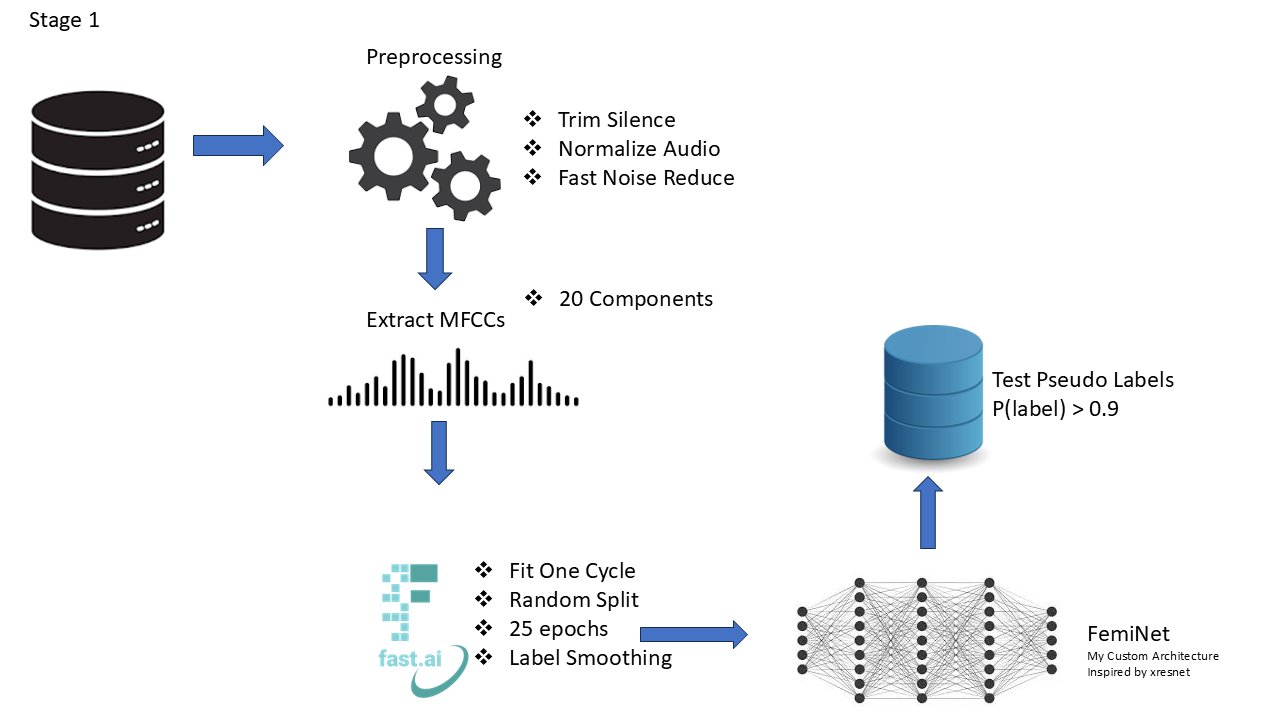

> **Note:** This notebook is primarily focused on **Stage One** of the solution! For **Stage Two** refer to notebook 2 


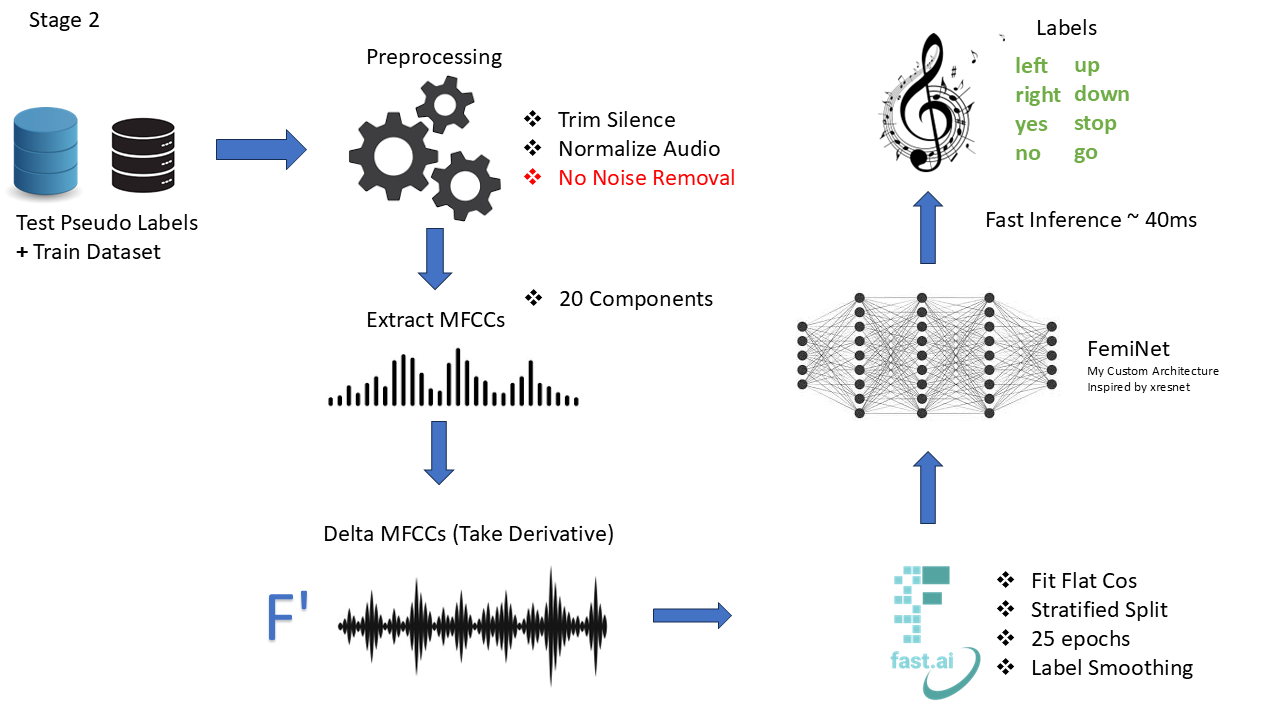

### 📁 Data Loading and Setup

- Loaded the training, test, and sample submission data using `pandas`.
- Classes: are `left` `down` `go` `right` `up` `yes` `no` `stop`


In [1]:
import pandas as pd
import librosa
import numpy as np
import matplotlib.pyplot as plt
import librosa.display
from fastai.vision.all import *

# Load train and test data
train = pd.read_csv("/kaggle/input/techcabal-audio-dataset/files/Train.csv")
test = pd.read_csv("/kaggle/input/techcabal-audio-dataset/files/Test_1.csv")
ss = pd.read_csv("/kaggle/input/techcabal-audio-dataset/files/SampleSubmission_1.csv")

# Define the folder where audio files are stored
AUDIO_FOLDER = "/kaggle/input/techcabal-audio-dataset/audio/TechCabal Ewe Audio Files"

# Check the available classes
classes = train['class'].unique()
print(f"Classes: {classes}")


Classes: ['left' 'down' 'go' 'right' 'up' 'yes' 'no' 'stop']


In [2]:
train.head()

,id,audio_filepath,duration,class
0,id_6nazjwygdl,id_6nazjwygdl.wav,1.984,left
1,id_jpwl97yilf,id_jpwl97yilf.wav,2.027,down
2,id_9d131fb32p,id_9d131fb32p.wav,2.274,go
3,id_kat2oty4s0,id_kat2oty4s0.wav,2.176,down
4,id_g3hvae3jbe,id_g3hvae3jbe.wav,1.634,down


### 🔧 Install Noise Reduction Library

- Installed the `noisereduce` library to help with noise reduction in the audio preprocessing stag.


In [3]:
!pip install noisereduce -q

### 🎧 Audio Preprocessing Function

- Defined a function `load_and_preprocess` to handle audio file loading and preprocessing.
- Steps include:
  - Loading the audio file with a sample rate of 16kHz.
  - Trimming silence from the audio.
  - Normalizing the audio to a range between -1 and 1.
  - Applying noise reduction using the `noisereduce` library for cleaner audio.


In [4]:
import librosa.effects
import noisereduce as nr  # For noise reduction

def load_and_preprocess(filepath, sr=16000):
    # Load the audio file
    audio, sample_rate = librosa.load(filepath, sr=sr)
    
    # Trim silence from the beginning and end
    audio, _ = librosa.effects.trim(audio)
    
    # Normalize the audio to have values between -1 and 1
    audio = librosa.util.normalize(audio)
    
    # Experiment with these values for faster noise reduction
    audio = nr.reduce_noise(y=audio, sr=sample_rate, n_fft=512, hop_length=128, stationary=True)

    return audio, sample_rate


### 🔍 MFCC Extraction and Visualization

- `extract_mfcc`: Extracts **MFCC (Mel Frequency Cepstral Coefficients)** features from the preprocessed audio.
- `plot_mfcc`: Visualizes the extracted MFCCs as a heatmap using `librosa.displasis.


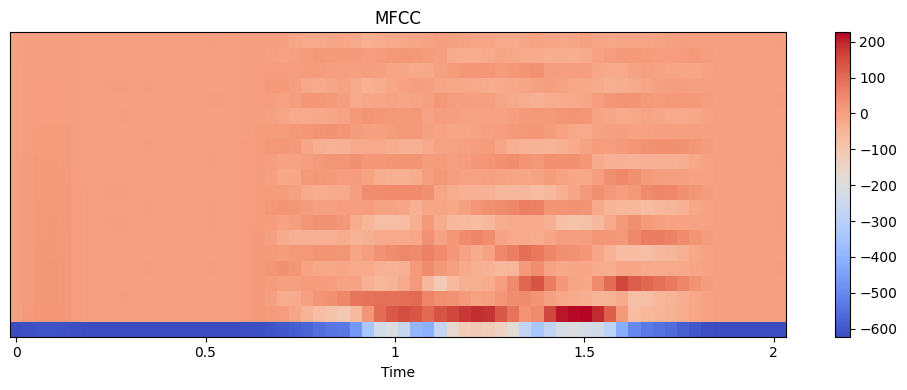

In [5]:
def extract_mfcc(audio, sr=16000, n_mfcc=20):
    # Extract MFCC features
    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)
    return mfcc

def plot_mfcc(mfcc, sr=16000):
    # Visualize MFCCs
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mfcc, sr=sr, x_axis='time')
    plt.colorbar()
    plt.title('MFCC')
    plt.tight_layout()
    plt.show()

# Example to test preprocessing and MFCC extraction
audio, sr = load_and_preprocess(f"{AUDIO_FOLDER}/{train['audio_filepath'].iloc[1]}")
mfcc = extract_mfcc(audio, sr)
plot_mfcc(mfcc)



### 📏 MFCC Padding/Trimming and Audio-to-MFCC Transforms.
- `AudioToMFCC`: A custom `Transform` class that:
  - Loads and preprocesses audio.
  - Extracts MFCC features and applies padding or trimming.
  - Adds a channel dimension to make the MFCC compatible with CNNs for model trai
- `pad_or_trim` function: Pads or crops MFCC features to a fixed length (e.g., 128 time steps) to ensure consistency across all samples.ning.


In [6]:
import torch

# Function to pad or crop MFCC to a fixed size (e.g., 128 time steps like in my case)
def pad_or_trim(mfcc, fixed_length=128):
    # Get the current length of the time dimension
    current_length = mfcc.shape[-1]

    if current_length > fixed_length:
        # Crop if the MFCC is longer than the fixed size
        return mfcc[:, :fixed_length]
    elif current_length < fixed_length:
        # Pad with zeros if the MFCC is shorter than the fixed size
        pad_amount = fixed_length - current_length
        return torch.nn.functional.pad(mfcc, (0, pad_amount), mode='constant')
    else:
        # If the size matches, return as is
        return mfcc

# AudioToMFCC transform to include padding/cropping
class AudioToMFCC(Transform):
    def __init__(self, folder, fixed_length=128):
        self.folder = folder
        self.fixed_length = fixed_length

    def encodes(self, row):
        file_path = f"{self.folder}/{row['audio_filepath']}"
        audio, sr = load_and_preprocess(file_path)
        mfcc = extract_mfcc(audio, sr)
        
        # Ensure all MFCC tensors have the same time dimension
        mfcc = pad_or_trim(tensor(mfcc), self.fixed_length)
        
        return mfcc.unsqueeze(0)  # Add channel dimension for CNN
    
    def decodes(self, x):
        return x

### 📊 DataBlock and DataLoaders Setup
- Built a `DataBlock` using:
  - MFCC features as input (`TransformBlock` with custom transform).
  - The audio class labels as output (`CategoryBlock`).
  - A random 80/20 split for training and validation.
- Created `DataLoaders` with a batch size of 256.


In [7]:
# Define the path to audio files
aud_fold = "/kaggle/input/techcabal-audio-dataset/audio/TechCabal Ewe Audio Files/"

# Set the fixed length for MFCC time steps
fixed_length = 128  # You can experiment with this size

# Instantiate the custom transform to use in the DataBlock
audio_transform = AudioToMFCC(aud_fold, fixed_length=fixed_length)

# Define a DataBlock that uses our custom audio transform
audio_block = DataBlock(
    blocks=(TransformBlock(type_tfms=audio_transform), CategoryBlock),
    get_x=lambda r: r,  # Get full row, transformation is handled by `audio_transform`
    get_y= ColReader('class'),  # Get the class (e.g., 'left', 'right', etc.)
    splitter=RandomSplitter(valid_pct=0.2),  # Split data into training and validation sets
)

# Create the DataLoaders
dls = audio_block.dataloaders(train, bs=256)

### 🖼️ Visualizing MFCCs from a DataLoader

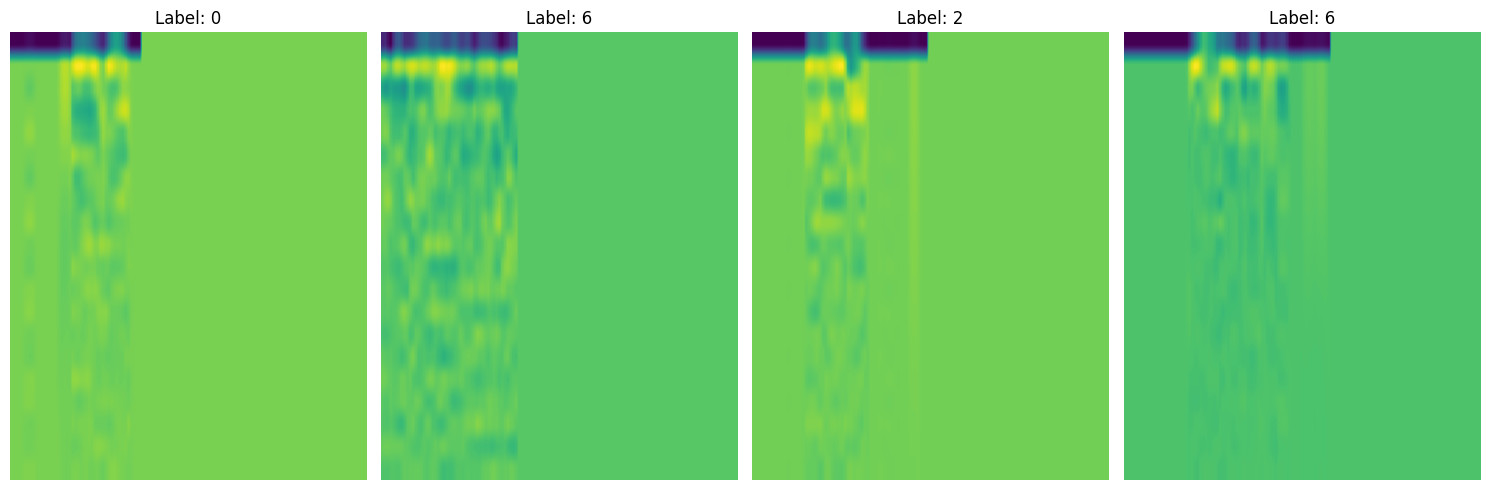

In [8]:
import matplotlib.pyplot as plt

# Custom function to display a batch of MFCCs
def show_mfcc_batch(dl, n=4):
    """Displays a batch of MFCCs from the DataLoader"""
    xb, yb = dl.one_batch()  # Get one batch of data
    fig, axs = plt.subplots(1, n, figsize=(15, 5))

    for i in range(n):
        mfcc = xb[i].squeeze(0).cpu().numpy()  # Remove channel dimension, convert to numpy
        axs[i].imshow(mfcc, cmap='viridis', aspect='auto')
        axs[i].set_title(f"Label: {yb[i].item()}")
        axs[i].set_axis_off()

    plt.tight_layout()
    plt.show()

# Use the custom show function to display MFCCs from the DataLoader
show_mfcc_batch(dls.train, n=4)



### 🧠 FemiNet: Custom CNN Architecture

- Created **FemiNet**, a custom Convolutional Neural Network (CNN) inspired by residual networks:
- Created a `Learner` using the **FemiNet** model, with **Label Smoothing Cross Entropy** as the loss function.


In [13]:
import torch
import torch.nn as nn
from fastai.vision.all import *

class FemiNet(nn.Module):
    def __init__(self, num_classes):
        super(FemiNet, self).__init__()
        self.features = nn.Sequential(
            # Increase input/output channels for a larger model
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Adding more residual blocks with increased channels
            self._make_layer(64, 128, 2),
            self._make_layer(128, 256, 1),
            
            nn.AdaptiveAvgPool2d((1, 1))
        )
        self.fc = nn.Linear(256, num_classes)

    def _make_layer(self, in_channels, out_channels, blocks):
        layers = []
        for _ in range(blocks):
            layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1))
            layers.append(nn.BatchNorm2d(out_channels))
            layers.append(nn.ReLU(inplace=True))
            in_channels = out_channels
        return nn.Sequential(*layers)
    
    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

# Number of classes should match your dataset
model = FemiNet(num_classes=len(dls.vocab))

learn = Learner(dls, model, LabelSmoothingCrossEntropyFlat(), metrics=accuracy)


### 🚀 Model Training

In [16]:
learn.fit_one_cycle(
    25 
)


epoch,train_loss,valid_loss,accuracy,time
0,2.054819,2.068898,0.129456,05:21
1,1.977252,1.927009,0.379925,05:05
2,1.798905,1.331855,0.683865,05:04
3,1.553317,0.984425,0.825516,05:04
4,1.316463,1.175738,0.699812,05:04
5,1.121352,1.894206,0.530957,05:07
6,0.972787,1.071763,0.771107,05:05
7,0.857303,1.250039,0.702627,05:03
8,0.770611,0.782953,0.900563,05:04
9,0.699839,0.657901,0.957786,05:03


### 🔍 Inference Function

- `predict_audio`: Handles inference for a single audio file by:
  - Loading and preprocessing the audio.
  - Extracting MFCC features.
  - Converting MFCCs into a tensor format suitable for model input.
  - Using the trained model to predict the class of the audio file.


In [17]:
test = pd.read_csv("/kaggle/input/techcabal-audio-dataset/files/Test_1.csv")#-.head()
test.head()

,id,audio_filepath,duration
0,id_u5iqtgjzhx,id_u5iqtgjzhx.wav,2.35800
1,id_l7ebzcfk5e,id_l7ebzcfk5e.wav,3.22100
2,id_jbzci8uepl,id_jbzci8uepl.wav,2.94898
3,id_jzil0fw5vs,id_jzil0fw5vs.wav,4.33100
4,id_o7mrvf5wj7,id_o7mrvf5wj7.wav,1.85600


In [18]:
# Define a function to handle inference for a single audio file
def predict_audio(filepath):
    # Load and preprocess the audio file
    audio, sr = load_and_preprocess(filepath)
    
    # Extract MFCC features
    mfcc = extract_mfcc(audio, sr)
    
    # Convert MFCC into a format suitable for the FastAI model (tensor)
    mfcc_tensor = tensor(mfcc).unsqueeze(0)  # Add channel dimension for CNN (1, channels, height, width)
    
    # Get prediction
    pred_class, pred_idx, outputs = learn.predict(mfcc_tensor)
    
    return pred_class, pred_idx, outputs

In [19]:
# Save model weights
learn.save('mini_audio_classifier_weights')

Path('models/mini_audio_classifier_weights.pth')

### 📝 Generating Predictions and Preparing Submission

- Looped through the test dataset to generate predictions and probabilities for each audio file using the `predict_audio` function.

In [20]:
%%capture
# Generate predictions without progress bar
preds = []
probs = []
for x in test['audio_filepath'].tolist():
    pred_class, pred_idx, outputs = predict_audio(f"{AUDIO_FOLDER}/{x}")
    preds.append(pred_class)
    probs.append(float(outputs[pred_idx]))

# Assign predictions to the test dataframe
test['pred'] = preds

# Prepare submission file
submission = test[['id', 'pred']].rename(columns={'pred': 'class'})
submission.to_csv('submission.csv', index=False)

In [21]:
submission["probabilities"] = probs
submission.to_csv('probabilities_submission.csv', index=False)

In [22]:
submission

,id,class,probabilities
0,id_u5iqtgjzhx,up,0.550909
1,id_l7ebzcfk5e,down,0.369853
2,id_jbzci8uepl,no,0.966653
3,id_jzil0fw5vs,stop,0.277155
4,id_o7mrvf5wj7,left,0.847983
...,...,...,...
2941,id_gx8hrglpc9,left,0.999888
2942,id_9bxbutuh8z,left,0.999716
2943,id_d0tudlf5gn,left,0.999958
2944,id_xuwlsfztrd,right,0.997809


## 🔚 The End of Part 1

If you're using this notebook to learn, feel free to submit the generated submission file. However, to fully leverage this solution, join us in **Notebook 2**, where we will explore how to use pseudo labels for further improvements.


> **Continued in Notebook 2** 📝


I am always open to assist enthusiasts with difficulties they are facing in Machine learning and Deep learning. Feel free to reach out to me: most preferably LinkedIn.

. [Twitter](https://twitter.com/olufemivictort).

. [Linkedin](https://www.linkedin.com/in/olufemi-victor-tolulope).

. [Github](https://github.com/osinkolu)

### Author: Olufemi Victor Tolulope